# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -r /content/drive/MyDrive/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 21.2 MB/s eta 0:00:00


In [3]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [4]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# superclass_df = pd.read_csv('superclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in superclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(superclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_lr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'superclass': row['diagnostic_superclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed.pkl')

df_orig = pd.read_pickle('/content/drive/MyDrive/nico/df_processed_250.pkl')
df_orig

,record_name,superclass,signal,age,sex
0,records500/00000/00001_hr,['NORM'],"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1
1,records500/00000/00002_hr,['NORM'],"[[-0.011243299508205044, 0.09023407534582495, ...",19.0,0
2,records500/00000/00003_hr,['NORM'],"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1
3,records500/00000/00004_hr,['NORM'],"[[-0.04137347387754445, -0.11622565135690588, ...",24.0,0
4,records500/00000/00005_hr,['NORM'],"[[-0.03003880948325483, -0.43121334841072106, ...",19.0,1
...,...,...,...,...,...
16239,records500/21000/21833_hr,['STTC'],"[[-0.04391078902957227, -0.02257351658386932, ...",67.0,1
16240,records500/21000/21834_hr,['NORM'],"[[-0.026419722051677138, 0.0036079393377764384...",300.0,0
16241,records500/21000/21835_hr,['STTC'],"[[0.06267955458986217, 0.0552252383461329, -0....",59.0,1
16242,records500/21000/21836_hr,['NORM'],"[[-0.03373067418018933, -0.02617115333028704, ...",64.0,1


# Preprocessing

## downsampling NORM class

In [5]:
# # Filter out the "NORM" class

# norm_df = df_orig[df_orig['superclass'] == '[\'NORM\']']

# # Randomly sample 6000 records from the "NORM" class to be removed
# to_remove = norm_df.sample(6000, random_state=1)

# # Remove these from the original df
# df = df_orig.drop(to_remove.index)
# df = df.reset_index(drop=True)

# df
df = df_orig

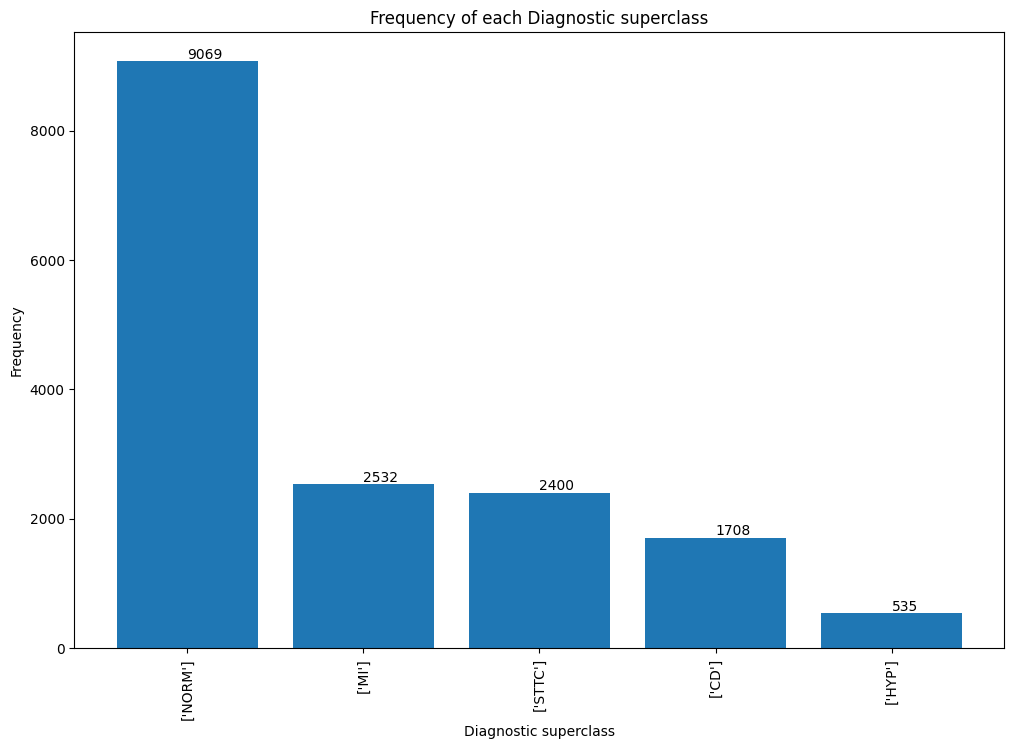

In [6]:
import matplotlib.pyplot as plt

# Convert any list-like objects in 'subclass' to strings
df_orig['superclass'] = df_orig['superclass'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Count the number of occurrences of each element in 'subclass'
superclass_c = df_orig['superclass'].value_counts()

# Plot the frequency of each subclass
plt.figure(figsize=(12,8))
bars = plt.bar(superclass_c.index, superclass_c.values)
plt.title('Frequency of each Diagnostic superclass')
plt.xlabel('Diagnostic superclass')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')

# Add count annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.show()


## One Hot

In [7]:
# Make sure each label is in a separate list
df['superclass'] = df['superclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['superclass'])
df_encoded = pd.concat([df.drop('superclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['CD'],['HYP'],['MI'],['NORM'],['STTC']
0,records500/00000/00001_hr,"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1,0,0,0,1,0
1,records500/00000/00002_hr,"[[-0.011243299508205044, 0.09023407534582495, ...",19.0,0,0,0,0,1,0
2,records500/00000/00003_hr,"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1,0,0,0,1,0
3,records500/00000/00004_hr,"[[-0.04137347387754445, -0.11622565135690588, ...",24.0,0,0,0,0,1,0
4,records500/00000/00005_hr,"[[-0.03003880948325483, -0.43121334841072106, ...",19.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
16239,records500/21000/21833_hr,"[[-0.04391078902957227, -0.02257351658386932, ...",67.0,1,0,0,0,0,1
16240,records500/21000/21834_hr,"[[-0.026419722051677138, 0.0036079393377764384...",300.0,0,0,0,0,1,0
16241,records500/21000/21835_hr,"[[0.06267955458986217, 0.0552252383461329, -0....",59.0,1,0,0,0,0,1
16242,records500/21000/21836_hr,"[[-0.03373067418018933, -0.02617115333028704, ...",64.0,1,0,0,0,1,0


SPLIT


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_encoded['signal'].tolist())
X_info = df_encoded[[]]  # age and sex as additional features
y = df_encoded.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=12
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=12
)

# Apply feature scaling (if needed) on the ECG signal data
# scaler = StandardScaler()
# X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
# X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
# X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


ECG Data Shapes:
Training data: (11370, 2500, 12)
Validation data: (2437, 2500, 12)
Test data: (2437, 2500, 12)

Info Data Shapes:
Training data: (11370, 0)
Validation data: (2437, 0)
Test data: (2437, 0)

Target Labels Shape:
Training labels: (11370, 5)
Validation labels: (2437, 5)
Test labels: (2437, 5)


## Upsample lowest class

In [9]:
# import numpy as np
# from sklearn.utils import resample

# # Get column names
# class_labels = y_train.columns

# # Get index of the max value in each row (which will be 1 in one-hot encoding)
# label_indices = np.argmax(y_train.values, axis=1)

# # Map the index to the corresponding class label
# y_train_single_column = np.array([class_labels[idx] for idx in label_indices])

# # Now create train_df
# train_df = pd.DataFrame({'signal': [signal for signal in X_ecg_train], 'superclass': y_train_single_column})


# def add_noise(data, noise_factor=0.01):
#     noise = np.random.normal(size=data.shape)
#     augmented_data = data + noise_factor * noise
#     return augmented_data

# # Separate the 'HYP' class
# hyp_df = train_df[train_df['superclass'] == '[\'HYP\']']

# # Determine how many instances you need to resample
# n_samples = 1000  # adjust this value as needed

# # Resample the 'HYP' class
# hyp_upsampled = resample(hyp_df,
#                          replace=True,  # sample with replacement
#                          n_samples=n_samples,  # to match number in majority class
#                          random_state=1)  # reproducible results

# # Add noise to the resampled 'HYP' data
# # Assuming 'ecg_data' column contains the ECG data

# hyp_upsampled['signal'] = hyp_upsampled['signal'].apply(add_noise)


# # Create labels for 'HYP' class
# hyp_label = np.zeros(len(class_labels))
# hyp_label[class_labels.get_loc('[\'HYP\']')] = 1  # Assuming 'HYP' is one of the labels

# # Count of original 'HYP' instances
# original_hyp_count = len(hyp_df)

# # Resample and add noise to the 'HYP' class
# hyp_upsampled = resample(hyp_df, replace=True, n_samples=n_samples, random_state=1)
# hyp_upsampled['signal'] = hyp_upsampled['signal'].apply(add_noise)

# # Calculate how many new 'HYP' instances have been created
# new_hyp_count = len(hyp_upsampled) - original_hyp_count

# # Create corresponding labels for the new 'HYP' instances
# new_hyp_labels = np.repeat([hyp_label], new_hyp_count, axis=0)

# # Add new 'HYP' labels to y_train
# y_train = np.vstack((y_train, new_hyp_labels))

# # Combine the upsampled 'HYP' class with the rest of the training data
# train_df = pd.concat([train_df[train_df['superclass'] != '[\'HYP\']'], hyp_upsampled])
# train_df = train_df.reset_index(drop=True)

# # Transform 'train_df' back into your training dataset 'X_ecg_train'
# X_ecg_train = np.stack(train_df['signal'].values)



# # Choose one signal from the upsampled dataframe
# original_signal = hyp_upsampled['signal'].iloc[0]

# # Apply noise to this signal
# noisy_signal = add_noise(original_signal)

# # Plot original signal (first lead)
# plt.figure(figsize=(15, 3))
# plt.plot(original_signal[:, 0])  # select the first lead
# plt.title("Original ECG Signal (Lead 1)")
# plt.show()

# # Plot noisy signal (first lead)
# plt.figure(figsize=(15, 3))
# plt.plot(noisy_signal[:, 0])  # select the first lead
# plt.title("Noisy ECG Signal (Lead 1)")
# plt.show()



## Distribution of diseases SNOMED

In [10]:
# plt.figure(figsize=(10, 6))

# # Bar chart
# bars = plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)

# # Add data values to the top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

# plt.xlabel('SNOMED Disease Code')
# plt.ylabel('Number of Patients')
# plt.title('Distribution of Diseases')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


## test display

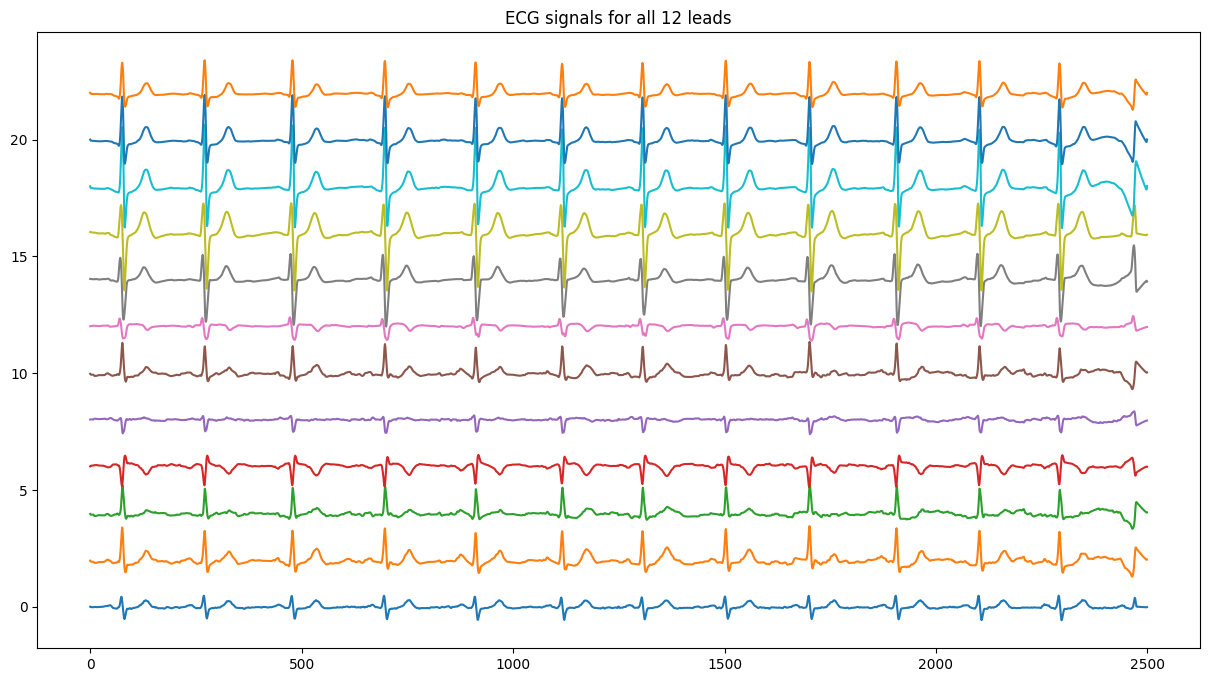

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))

# Create a list to store all ECG signals
all_ecgs = []

# Iterate over the 12 leads
for i in range(12):
    single_ecg = []
    for sublist in df_encoded.loc[3,'signal']:  # Get the data for one patient
        single_ecg.append(sublist[i])  # Get data for one lead

    signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
    cleaned_ecg = signals["ECG_Clean"]

    all_ecgs.append(cleaned_ecg)

# Combine all ECG signals into a single 2D array
all_ecgs = np.stack(all_ecgs)

# Plot each ECG lead with a slight vertical shift for better visibility
for i, ecg in enumerate(all_ecgs):
    plt.plot(ecg + i*2)  # Shift each lead by 200 units

plt.title('ECG signals for all 12 leads')
plt.show()


## Remove last beat if incomplete

In [12]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=100)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



## Notch filer - 50hz cleaning

In [13]:
# # Define the sample rate and the frequencies for the notch and low-pass filters
# sample_rate = 100
# notch_freq = 50
# low_pass_freq = 15  # Adjust the low-pass frequency to maintain similar filtering characteristics

# def design_filters(sample_rate, notch_freq, low_pass_freq):
#     # Design the notch filter
#     nyquist = 0.5 * sample_rate
#     freq_ratio = notch_freq / nyquist
#     notch_filter = iirnotch(freq_ratio, 30)  # 30 is the quality factor of the filter

#     # Design the low-pass filter
#     low_pass_filter = butter(5, low_pass_freq / nyquist, btype='low')

#     return notch_filter, low_pass_filter

# # Design the filters
# notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)
# # Define a function to apply the filters
# def apply_filters(data, notch_filter, low_pass_filter):
#     # Apply the notch filter
#     data = lfilter(*notch_filter, data)

#     # Apply the low-pass filter
#     data = lfilter(*low_pass_filter, data)

#     return data
# # Apply the filters to the data
# print(df_encoded.shape)
# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
# print(df_encoded.shape)


## Smoothen signal cleaning

In [14]:
# # def moving_average(signal, window_size):
# #     # If the signal has more than one channel, apply the moving average to each channel
# #     if signal.ndim > 1:
# #         return np.array([np.convolve(channel, np.ones(window_size) / window_size, mode='same') for channel in signal.T]).T
# #     # If the signal is only one channel, apply the moving average normally
# #     else:
# #         return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: moving_average(signal, window_size=3))

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: butter_lowpass_filter(signal, cutoff, fs, order))

# import pywt
# from scipy.stats import median_abs_deviation as mad

# def maddest(d, axis=None):  # Mean Absolute Deviation
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# def wavelet_smooth(signal, wavelet="db5", level=1):
#     coeff = pywt.wavedec(signal, wavelet, mode="per")
#     sigma = (1/0.6745) * maddest(coeff[-level])
#     uthresh = sigma * np.sqrt(2*np.log(len(signal)))
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in coeff[1:])
#     reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
#     return reconstructed_signal

# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: wavelet_smooth(signal))



## Remove Outliers

In [15]:

# # Compute the mean and standard deviation for each record
# means = np.array([np.mean(record) for record in df_encoded['signal']])
# std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# # Compute the average mean and standard deviation
# avg_mean = np.mean(means)
# avg_std_dev = np.mean(std_devs)

# # Compute the standard deviation of the means and standard deviations
# std_mean = np.std(means)
# std_std_dev = np.std(std_devs)

# # Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
# outlier_indices = np.where(
#     (np.abs(means - avg_mean) > 3 * std_mean) |
#     (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
# )[0]

# # Remove outliers from df
# df_cleaned = df_encoded.drop(outlier_indices)
# print(df_cleaned.shape)
# print(len(df_cleaned['signal'][0]))
# print(df_cleaned['signal'][0][0])
# #df_cleaned = df_encoded

## Normalization

In [16]:
# from tqdm import tqdm

# def normalize_patient_signals(patient_signals, patient_index):
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     patient_ecgs_normalized = []

#     for i in range(12):
#         single_ecg = patient_signals[:, i]

#         try:
#             signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
#             cleaned_ecg = signals["ECG_Clean"]

#             # Normalize the ECG signal
#             normalized_ecg = scaler.fit_transform(cleaned_ecg.to_numpy().reshape(-1, 1))

#             # Center the normalized ECG signal around 0
#             normalized_centered_ecg = normalized_ecg - np.mean(normalized_ecg)
#             patient_ecgs_normalized.append(normalized_centered_ecg.flatten())

#         except ValueError:
#             print(f"Error processing ECG signal for patient at index {patient_index}. Plotting signal and skipping...")
#             plt.figure(figsize=(10, 4))
#             plt.plot(single_ecg)
#             plt.title(f'ECG signal causing error for patient at index {patient_index}')
#             plt.show()
#             return None  # Return None to indicate an error

#     # Combine all normalized ECG signals for current patient into a single 2D array
#     return np.stack(patient_ecgs_normalized)


# # Apply the function to each row in the 'signal' column, and also pass the index to the function
# for index in tqdm(df_encoded.index):
#     df_encoded.at[index, 'signal'] = normalize_patient_signals(df_encoded.loc[index, 'signal'], index)

# # Drop rows where 'signal' is None (i.e., the ECG processing failed)
# df_encoded = df_encoded.dropna(subset=['signal'])


# df_cleaned = df_encoded


In [17]:
# def minmax_scale_image(image):
#     min_val = image.min()
#     max_val = image.max()
#     scaled_image = (image - min_val) / (max_val - min_val)
#     return scaled_image

# # Apply the minmax_scale_image function to each 2D image in the 'signal' column
# df_encoded['signal'] = df_encoded['signal'].apply(minmax_scale_image)


Random Forest Test


In [18]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Flatten the data
# X_ecg_train_flattened = X_ecg_train.reshape(X_ecg_train.shape[0], -1)
# X_ecg_val_flattened = X_ecg_val.reshape(X_ecg_val.shape[0], -1)
# X_ecg_test_flattened = X_ecg_test.reshape(X_ecg_test.shape[0], -1)

# # Convert DataFrames to NumPy arrays and then to label-encoded form
# y_train_single = np.argmax(y_train.values, axis=1)
# y_val_single = np.argmax(y_val.values, axis=1)
# y_test_single = np.argmax(y_test.values, axis=1)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['auto']
# }

# # Create a base model
# rf = RandomForestClassifier(random_state=12)

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
#                            cv = 2, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(X_ecg_train_flattened, y_train_single)

# # Print the best parameters
# print(grid_search.best_params_)

# # Use the best model
# best_grid = grid_search.best_estimator_

# # Make predictions using the best model
# y_val_pred = best_grid.predict(X_ecg_val_flattened)


ResNet Test


In [19]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def residual_block(X, filters):
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv1D(filters, kernel_size=8, strides=1, padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(filters, kernel_size=5, strides=1, padding="same")(X)
    X = BatchNormalization()(X)

    # Add shortcut value to main path
    X_shortcut = Conv1D(filters, kernel_size=3, strides=1, padding="same")(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def create_model(input_shape=(2500,12), classes=5):
    # Define the input
    X_input = Input(input_shape)

    # Stage 1
    X = Conv1D(64, kernel_size=7, strides=2)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=3, strides=2)(X)

    # Stage 2
    X = residual_block(X, filters=64)

    # Stage 3
    X = residual_block(X, filters=128)

    # Stage 4
    X = residual_block(X, filters=256)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet')

    return model

# Call the function to create the model
model_resnet = create_model(input_shape=(2500, 12), classes=5)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model_resnet.summary()

history_resnet = model_resnet.fit(
    X_ecg_train,
    y_train,
    validation_data=(X_ecg_val, y_val),
    epochs=20,  # specify the number of epochs
    batch_size=32,  # specify your batch size
    #class_weight = class_weight
)


Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2500, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1247, 64)     5440        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1247, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1247, 64)     0           ['batch_normalization[0][0]'

77/77 [==============================] - 2s 16ms/step


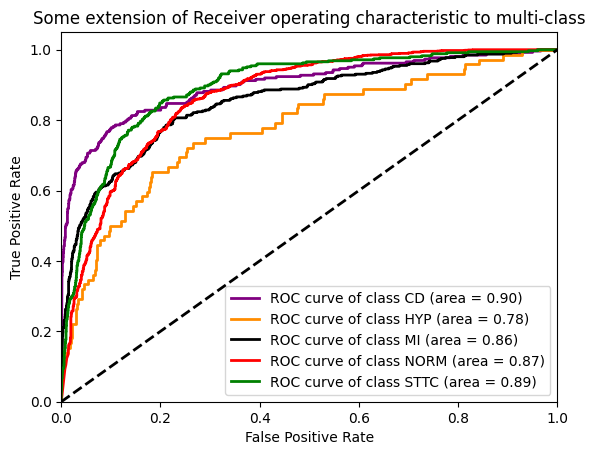

In [20]:
# Evaluate the model on the test set

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_pred = model_resnet.predict(X_ecg_test)  # assuming X_test is your test set
y_pred_binary = np.argmax(y_pred, axis=-1)
y_test_binary = np.argmax(y_test.values, axis=-1)

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

target_names = ['CD','HYP','MI','NORM','STTC']

# Plot all ROC curvesplt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()




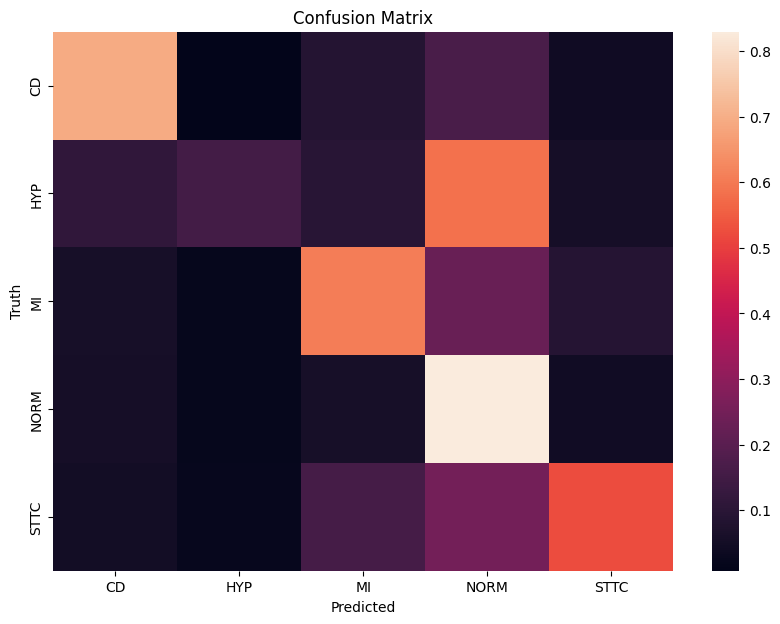

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm,xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

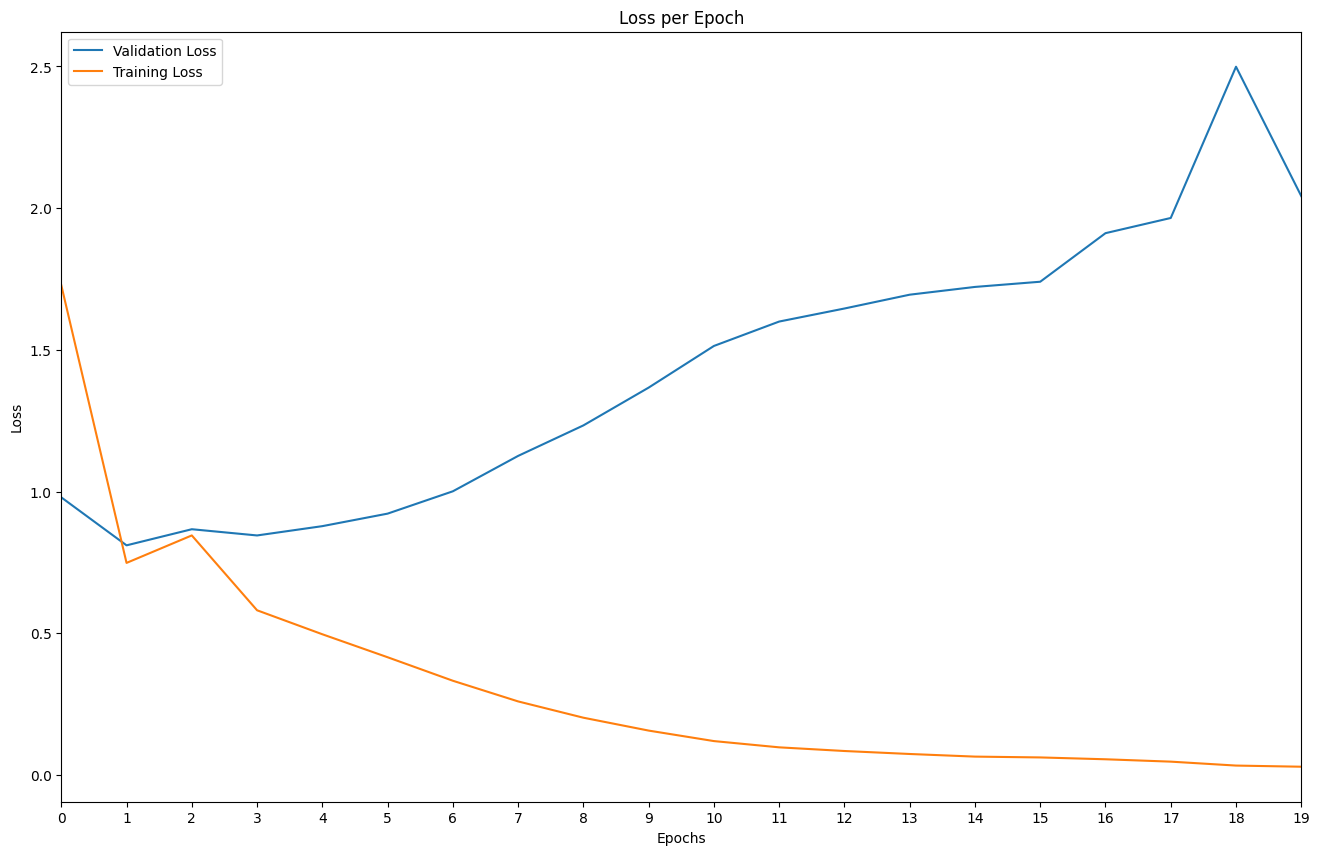

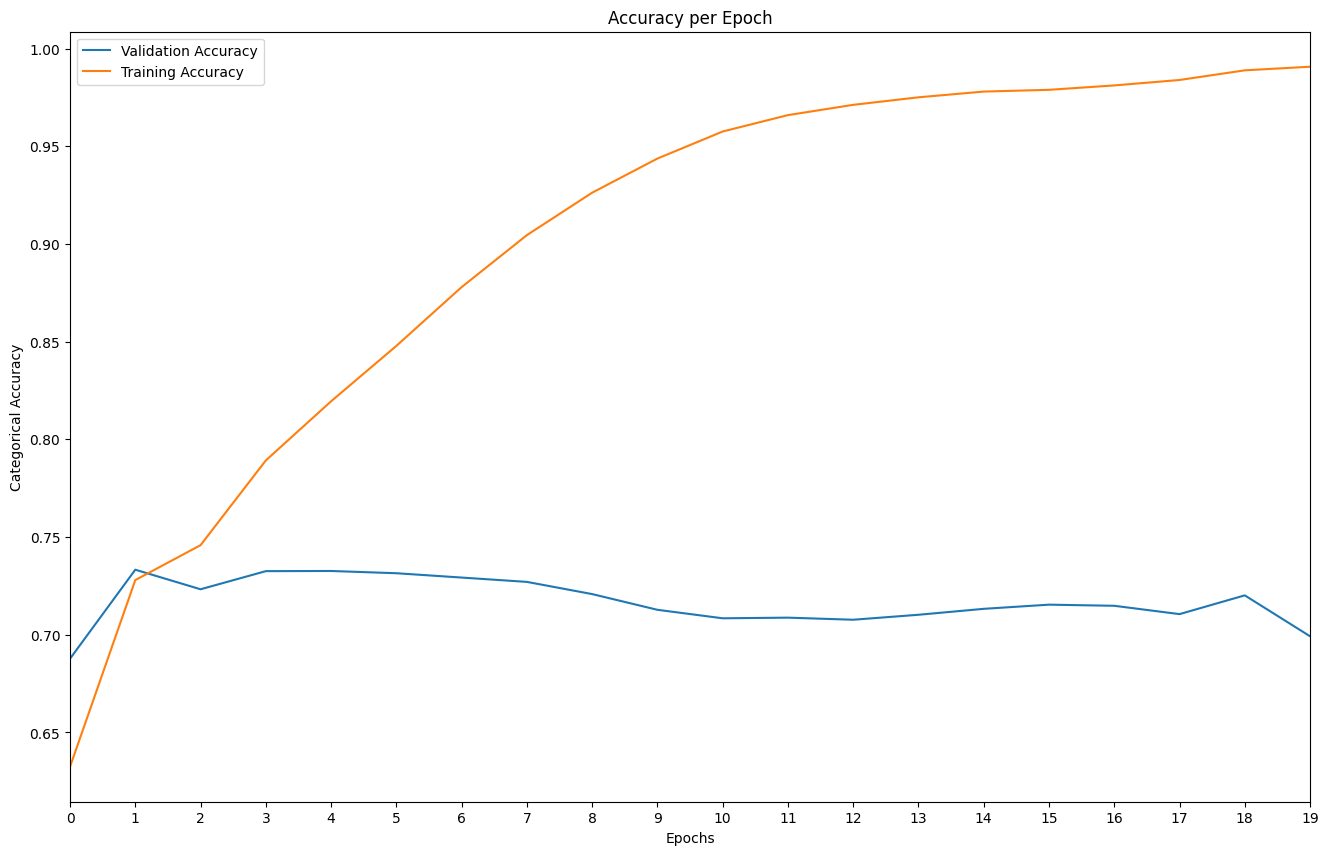

In [22]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_resnet)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_resnet)


## Transformer Test

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

inputs = layers.Input(shape=(2500, 12))
x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=512, dropout=0.1)

# The Global Average Pooling layer and output layer
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_tran = tf.keras.Model(inputs=inputs, outputs=outputs)

model_tran.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Pass it as a callback to the fit function
history_tran = model_tran.fit(X_ecg_train, y_train, batch_size=32, epochs=100, validation_data=(X_ecg_val, y_val), callbacks=[early_stopping])


Epoch 1/100
356/356 [==============================] - 136s 372ms/step - loss: 1.1076 - categorical_accuracy: 0.5952 - val_loss: 1.0277 - val_categorical_accuracy: 0.6229
Epoch 2/100
356/356 [==============================] - 131s 368ms/step - loss: 0.9999 - categorical_accuracy: 0.6319 - val_loss: 0.9766 - val_categorical_accuracy: 0.6459
Epoch 3/100
356/356 [==============================] - 132s 370ms/step - loss: 0.9626 - categorical_accuracy: 0.6498 - val_loss: 0.9458 - val_categorical_accuracy: 0.6504
Epoch 4/100
356/356 [==============================] - 131s 369ms/step - loss: 0.9410 - categorical_accuracy: 0.6597 - val_loss: 0.9316 - val_categorical_accuracy: 0.6713
Epoch 5/100
356/356 [==============================] - 131s 368ms/step - loss: 0.9266 - categorical_accuracy: 0.6609 - val_loss: 0.9217 - val_categorical_accuracy: 0.6717
Epoch 6/100
356/356 [==============================] - 131s 368ms/step - loss: 0.9129 - categorical_accuracy: 0.6677 - val_loss: 0.9000 - val_cat

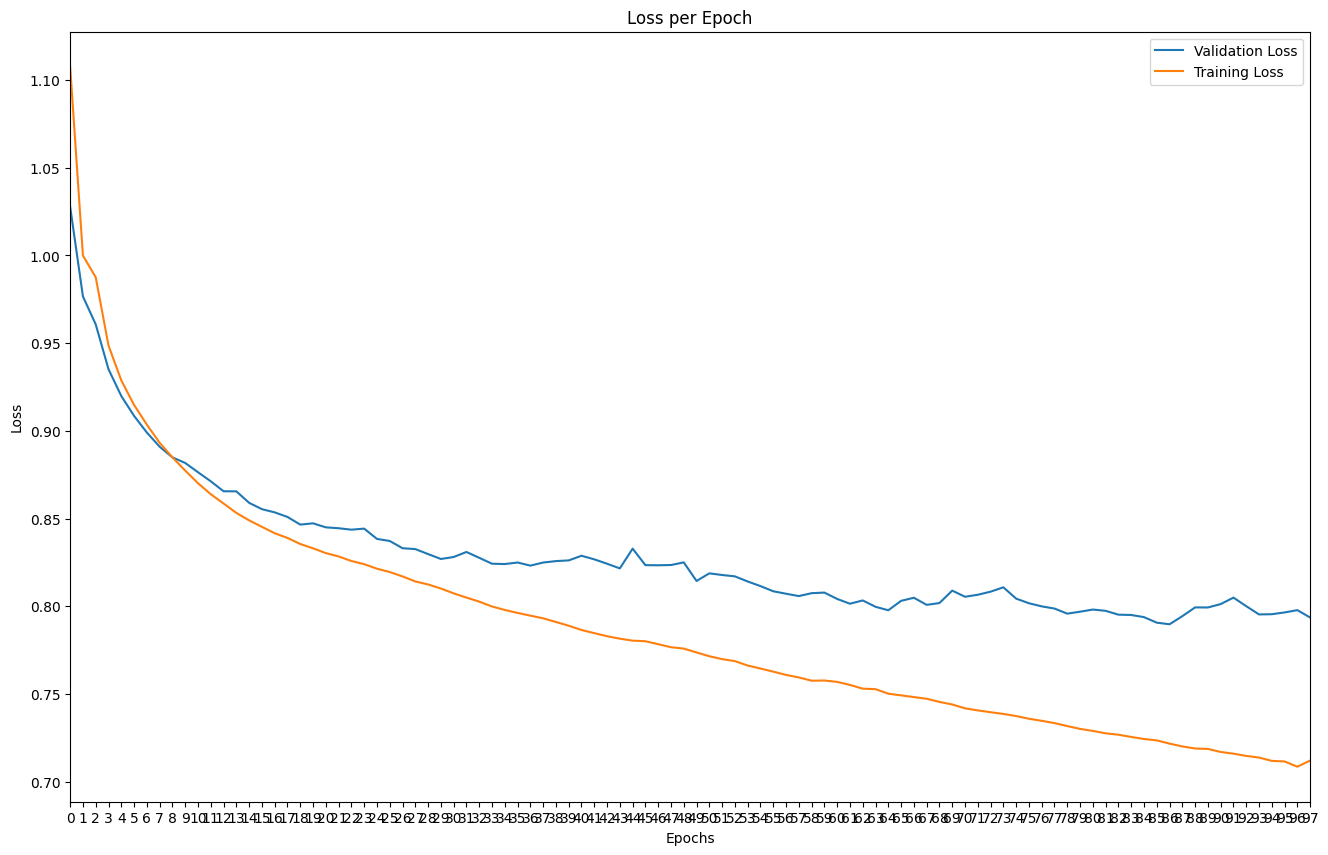

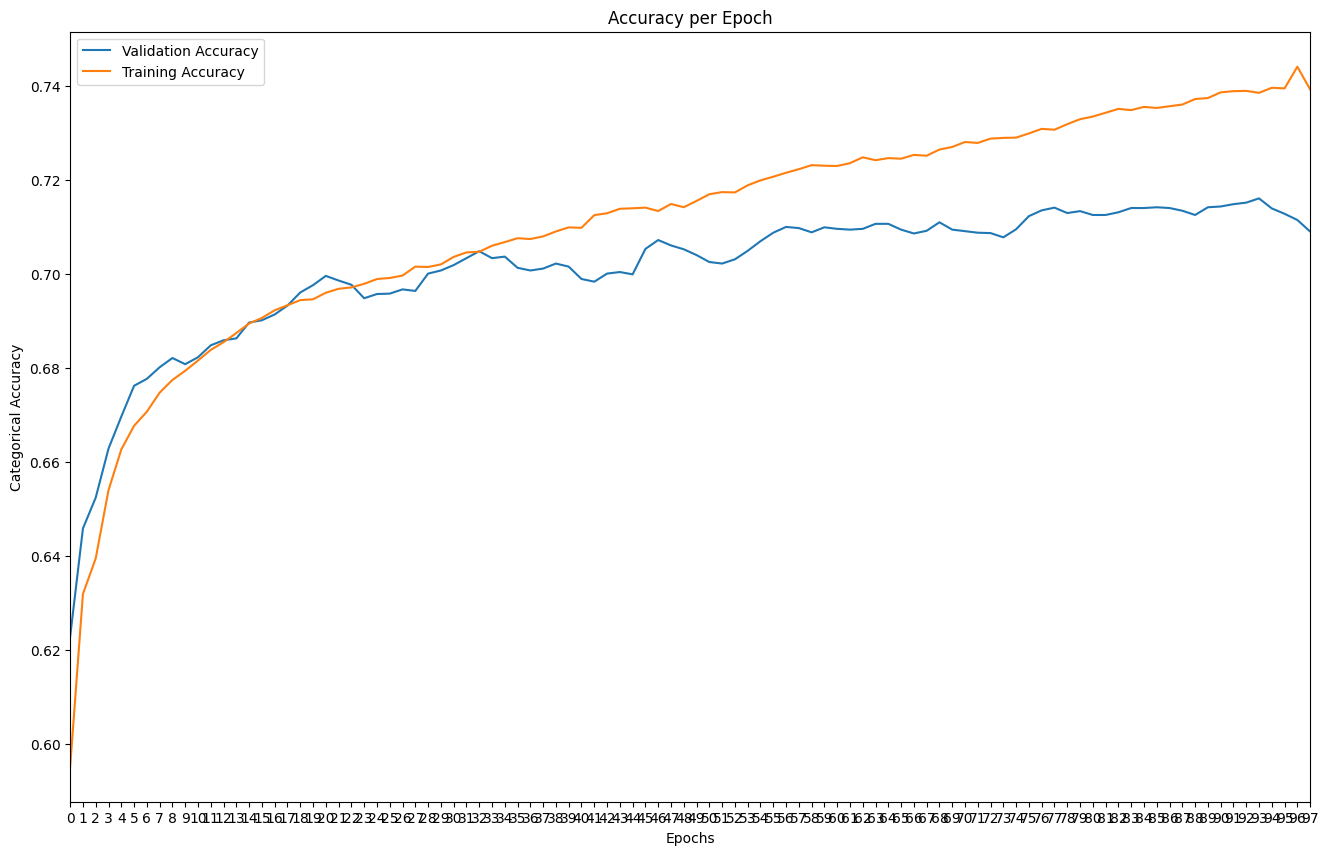

In [24]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_tran)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_tran)


In [25]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model_tran.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


77/77 [==============================] - 9s 111ms/step
ROC AUC Score: 0.8782314320886335
              precision    recall  f1-score   support

          CD       0.81      0.48      0.60       262
         HYP       0.45      0.21      0.29        72
          MI       0.73      0.25      0.37       403
        NORM       0.81      0.85      0.83      1350
        STTC       0.57      0.54      0.55       350

   micro avg       0.76      0.65      0.70      2437
   macro avg       0.67      0.47      0.53      2437
weighted avg       0.75      0.65      0.67      2437
 samples avg       0.65      0.65      0.65      2437



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


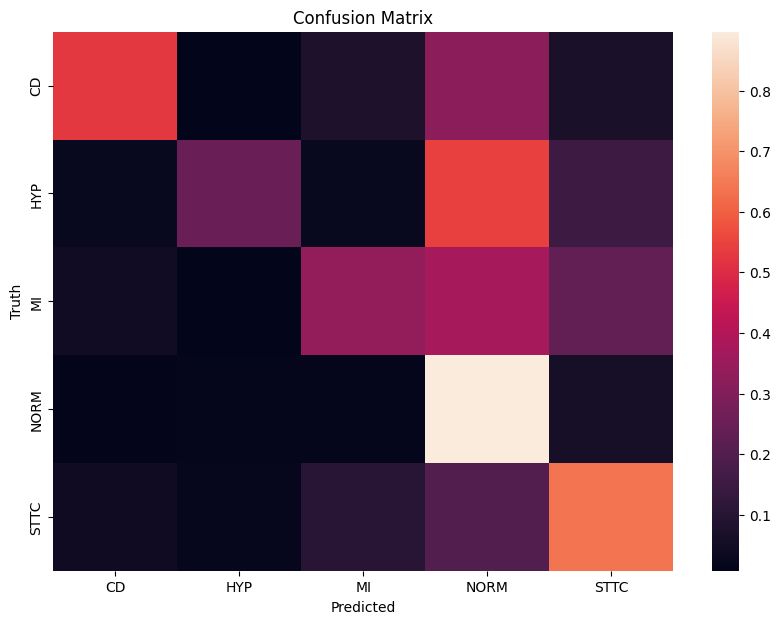

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, fmt='.2f',xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

RNN


In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model(input_shape=(2500, 12), num_classes=5):
    # Define an input for the series
    input_series = layers.Input(shape=input_shape)

    # Apply LSTM to the series
    x = layers.LSTM(64)(input_series)

    # Add a dense layer
    x = layers.Dense(64, activation="relu")(x)

    # Add a dropout layer for regularization
    x = layers.Dropout(0.5)(x)

    # Add the final classification (output) layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=input_series, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Call the function to create the model
model_rnn = create_model(input_shape=(2500, 12), num_classes=5)

# Print the model summary
model_rnn.summary()

# Then pass the data to the fit method
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Pass it as a callback to the fit function
history_rnn = model_rnn.fit(X_ecg_train, y_train, batch_size=32, epochs=100, validation_data=(X_ecg_val, y_val), callbacks=[early_stopping])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 2500, 12)]        0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                19712     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 24,197
Trainable params: 24,197
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
356/356 [==============================] - 

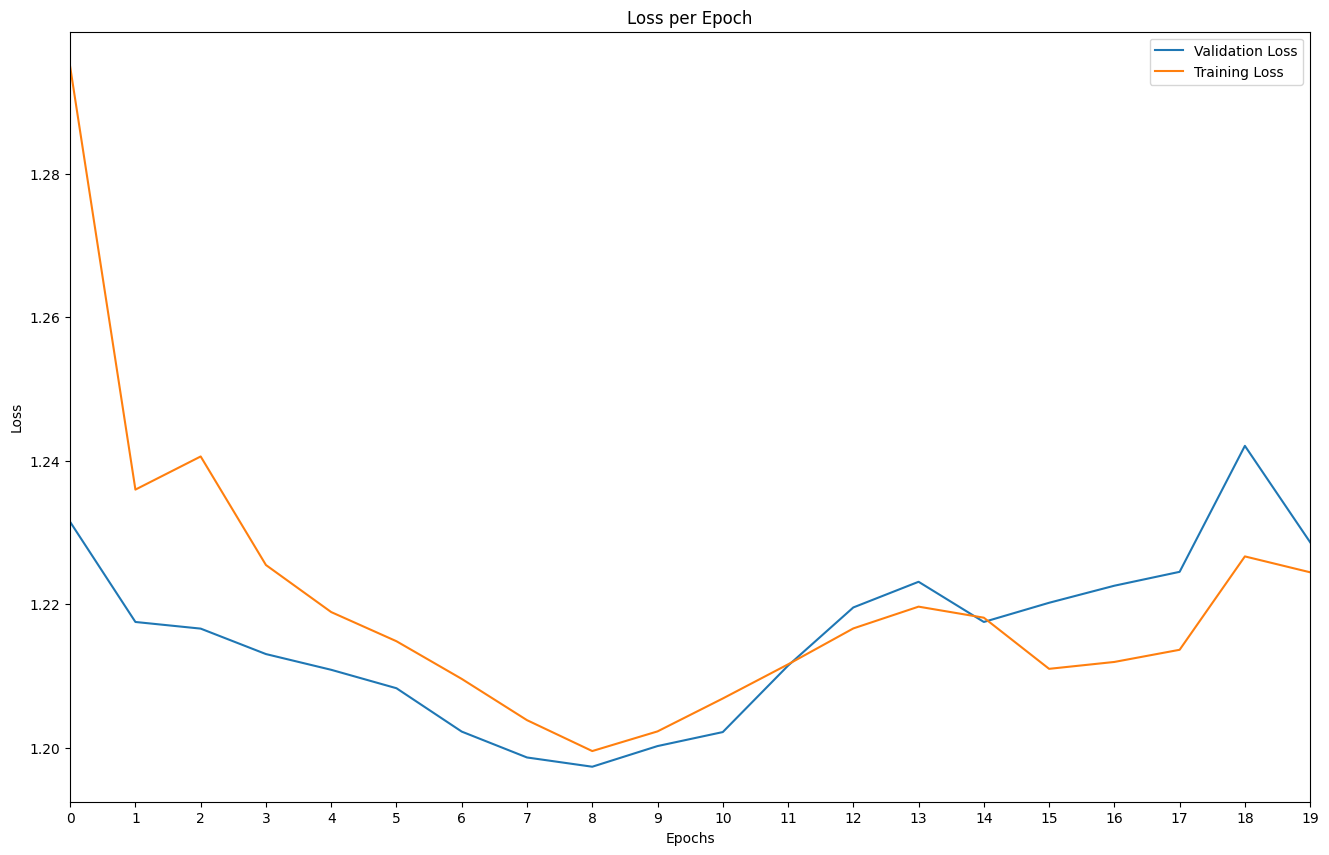

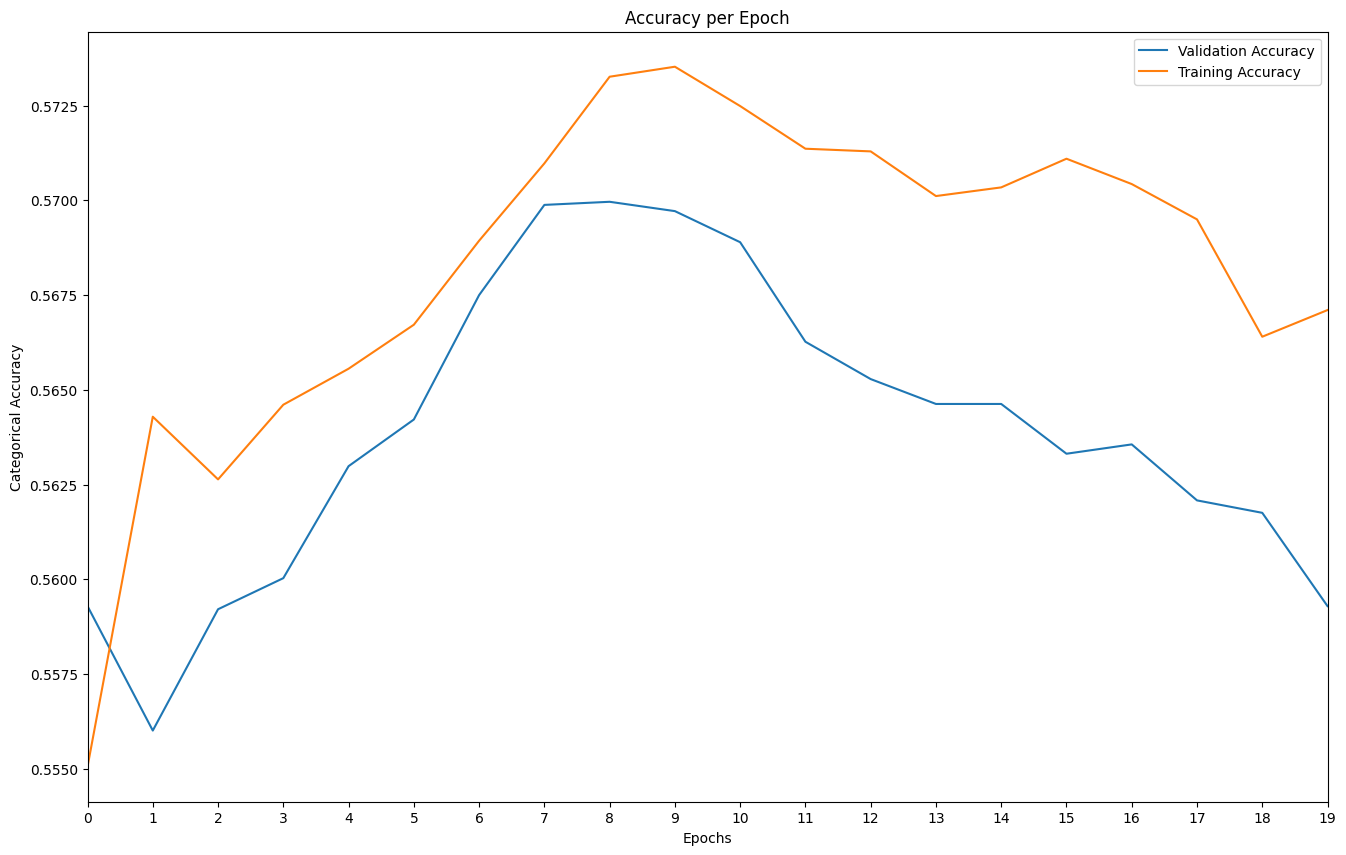

In [30]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_rnn)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_rnn)


In [31]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model_rnn.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# ['CD']	['HYP']	['MI']	['NORM']	['STTC']
target_names = ['CD','HYP','MI','NORM','STTC']
#target_names = ['CD','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


77/77 [==============================] - 2s 28ms/step
ROC AUC Score: 0.7796471070988921
              precision    recall  f1-score   support

          CD       0.49      0.07      0.13       262
         HYP       0.00      0.00      0.00        72
          MI       0.00      0.00      0.00       403
        NORM       0.58      0.93      0.71      1350
        STTC       0.00      0.00      0.00       350

   micro avg       0.58      0.52      0.55      2437
   macro avg       0.21      0.20      0.17      2437
weighted avg       0.37      0.52      0.41      2437
 samples avg       0.52      0.52      0.52      2437



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


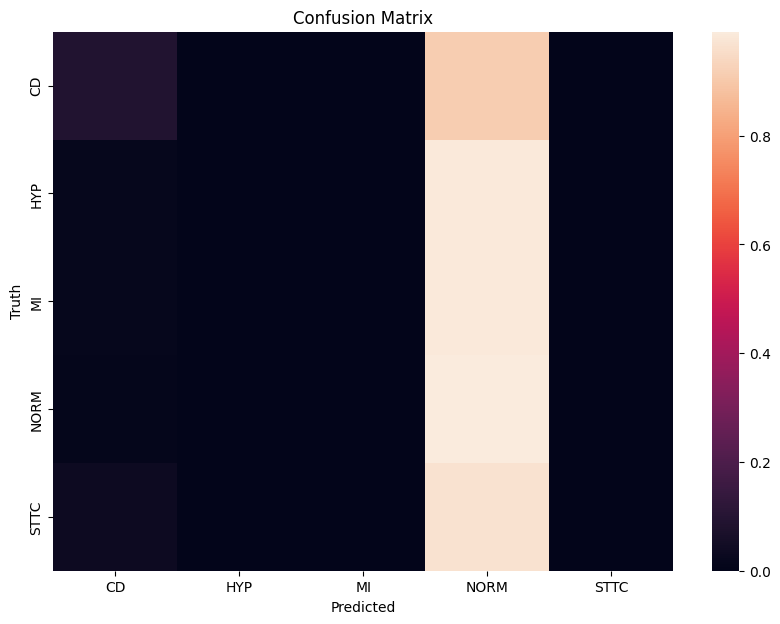

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


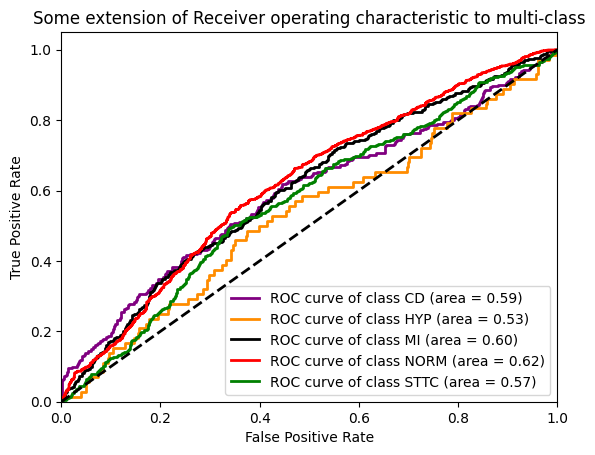

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curvesplt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# CNN


In [34]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)


# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 2500, 12)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 2494, 64)          5440      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 831, 64)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 825, 64)           28736     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 275, 64)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 275, 64)           0   

In [35]:
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)

#class_weight = {0: 0.3, 1: 1., 2: 0.3, 3: 0.15, 4: 0.3}
# Print the index and type of all non-array elements in X_ecg_train


history_12 = model.fit(
    X_ecg_train,
    y_train,
    validation_data=(X_ecg_val, y_val),
    epochs=20,  # specify the number of epochs
    batch_size=32,  # specify your batch size
    #class_weight = class_weight
)

Training data: (11370, 2500, 12)
Validation data: (2437, 2500, 12)
Test data: (2437, 2500, 12)
Epoch 1/20
356/356 [==============================] - 6s 12ms/step - loss: 1.0640 - categorical_accuracy: 0.6178 - val_loss: 0.8336 - val_categorical_accuracy: 0.7107
Epoch 2/20
356/356 [==============================] - 3s 10ms/step - loss: 0.8407 - categorical_accuracy: 0.7115 - val_loss: 0.7341 - val_categorical_accuracy: 0.7427
Epoch 3/20
356/356 [==============================] - 3s 10ms/step - loss: 0.7506 - categorical_accuracy: 0.7393 - val_loss: 0.7498 - val_categorical_accuracy: 0.7452
Epoch 4/20
356/356 [==============================] - 3s 10ms/step - loss: 0.6606 - categorical_accuracy: 0.7666 - val_loss: 0.7053 - val_categorical_accuracy: 0.7620
Epoch 5/20
356/356 [==============================] - 3s 10ms/step - loss: 0.6047 - categorical_accuracy: 0.7836 - val_loss: 0.6767 - val_categorical_accuracy: 0.7653
Epoch 6/20
356/356 [==============================] - 3s 10ms/step - l

In [36]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# ['CD']	['HYP']	['MI']	['NORM']	['STTC']
target_names = ['CD','HYP','MI','NORM','STTC']
#target_names = ['CD','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


77/77 [==============================] - 0s 4ms/step
ROC AUC Score: 0.9118793598686911
              precision    recall  f1-score   support

          CD       0.86      0.65      0.74       262
         HYP       0.48      0.22      0.30        72
          MI       0.74      0.60      0.66       403
        NORM       0.83      0.88      0.85      1350
        STTC       0.64      0.64      0.64       350

   micro avg       0.79      0.76      0.77      2437
   macro avg       0.71      0.60      0.64      2437
weighted avg       0.78      0.76      0.76      2437
 samples avg       0.76      0.76      0.76      2437



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_ecg_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


77/77 [==============================] - 0s 6ms/step - loss: 0.9014 - categorical_accuracy: 0.7702
Test Loss: 0.9013562798500061
Test Accuracy: 0.7702092528343201


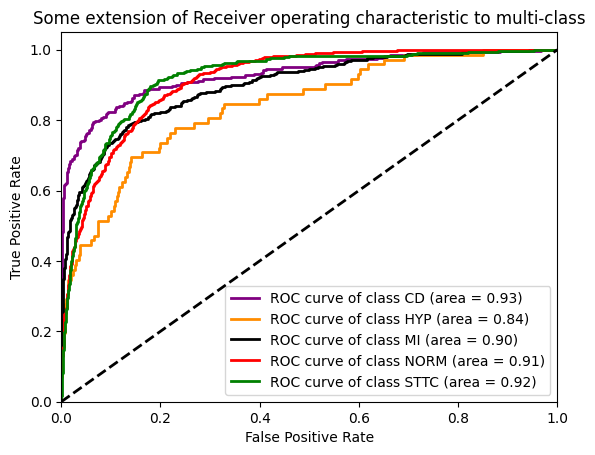

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curvesplt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


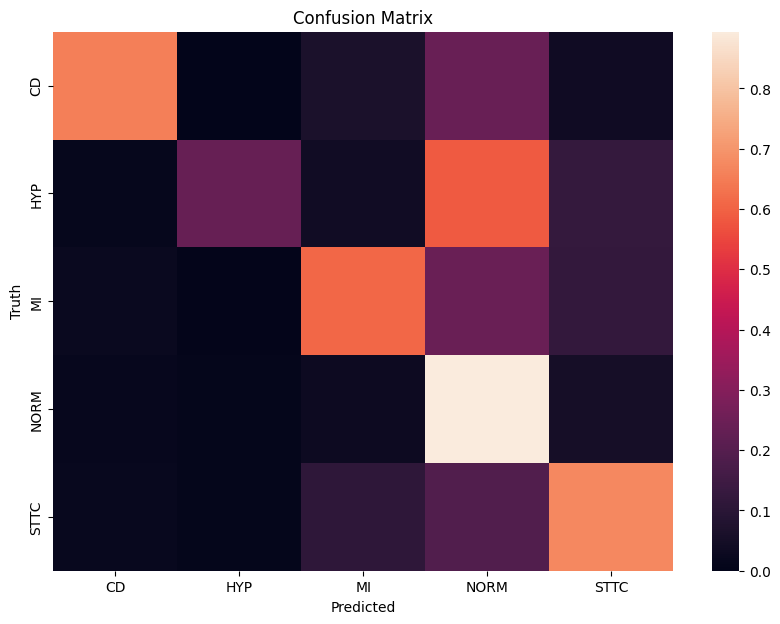

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm,xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 8 leads

In [40]:
df_cleaned = df_encoded
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :8])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 8))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_8 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 2500, 8)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, 2494, 64)          3648      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 831, 64)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 825, 64)           28736     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 275, 64)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 275, 64)           0   

102/102 [==============================] - 0s 3ms/step
ROC AUC Score: 0.8953524161280394
              precision    recall  f1-score   support

          CD       0.81      0.64      0.72       316
         HYP       0.35      0.09      0.14       103
          MI       0.70      0.53      0.60       516
        NORM       0.79      0.89      0.83      1815
        STTC       0.61      0.59      0.60       499

   micro avg       0.75      0.73      0.74      3249
   macro avg       0.65      0.55      0.58      3249
weighted avg       0.74      0.73      0.73      3249
 samples avg       0.73      0.73      0.73      3249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


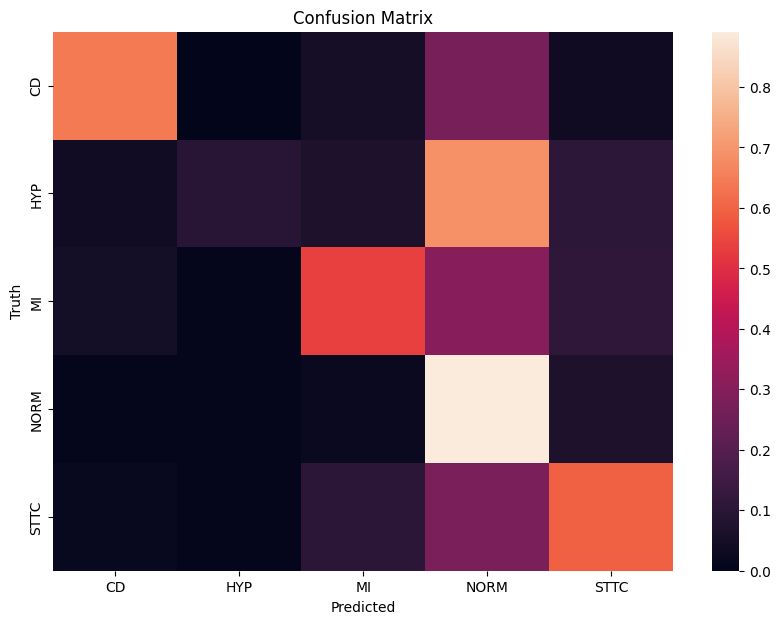

In [41]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 4 leads

In [42]:
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :4])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 4))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_4 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2500, 4)]         0         
                                                                 
 conv1d_16 (Conv1D)          (None, 2494, 64)          1856      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 831, 64)          0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 825, 64)           28736     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 275, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 275, 64)           0   

102/102 [==============================] - 0s 3ms/step
ROC AUC Score: 0.8797322253000923
              precision    recall  f1-score   support

          CD       0.69      0.64      0.66       316
         HYP       0.31      0.04      0.07       103
          MI       0.62      0.47      0.53       516
        NORM       0.79      0.88      0.84      1815
        STTC       0.57      0.48      0.52       499

   micro avg       0.73      0.70      0.72      3249
   macro avg       0.60      0.50      0.52      3249
weighted avg       0.71      0.70      0.70      3249
 samples avg       0.70      0.70      0.70      3249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


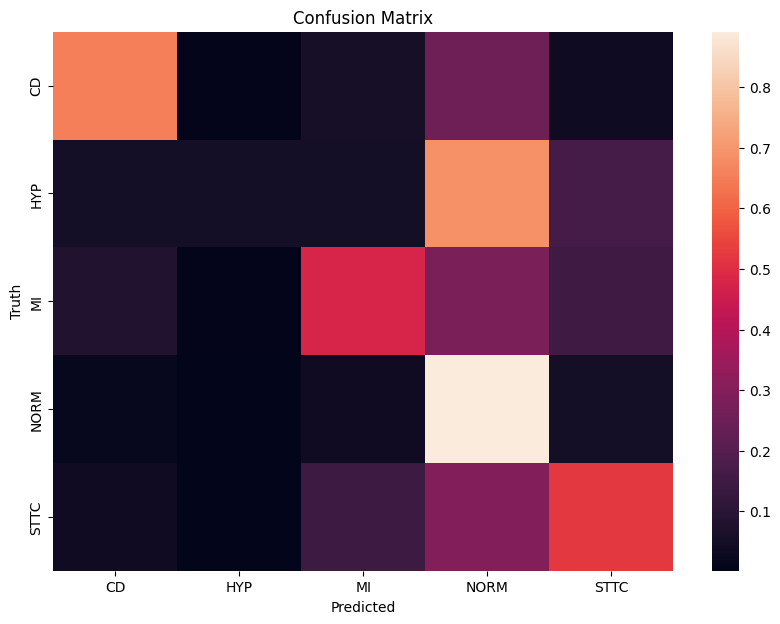

In [43]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 2 lead (II)

In [44]:
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :2])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 2))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_2 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 2500, 2)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 2494, 64)          960       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 831, 64)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 825, 64)           28736     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 275, 64)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 275, 64)           0   

102/102 [==============================] - 0s 3ms/step
ROC AUC Score: 0.8755001538935057
              precision    recall  f1-score   support

          CD       0.73      0.61      0.66       316
         HYP       0.40      0.02      0.04       103
          MI       0.57      0.49      0.53       516
        NORM       0.78      0.88      0.83      1815
        STTC       0.63      0.39      0.48       499

   micro avg       0.73      0.69      0.71      3249
   macro avg       0.62      0.48      0.51      3249
weighted avg       0.71      0.69      0.69      3249
 samples avg       0.69      0.69      0.69      3249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


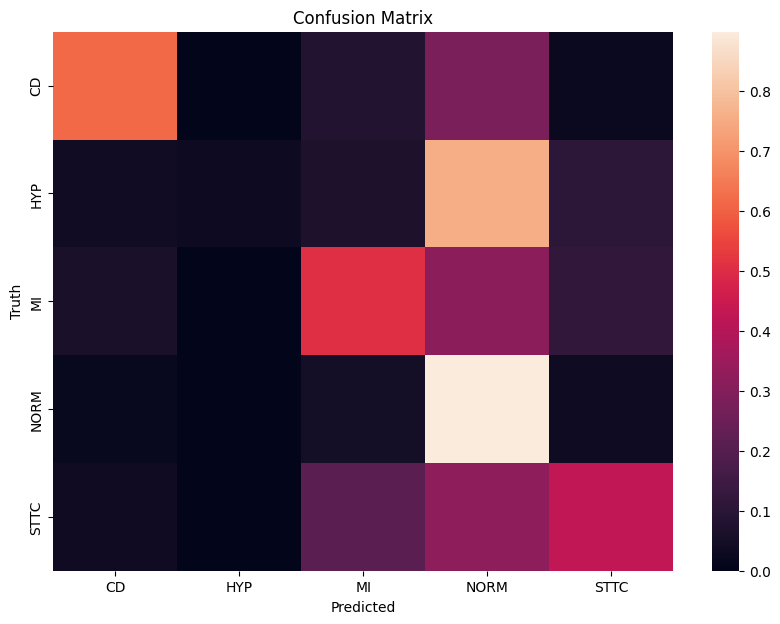

In [45]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 1 lead (II)

In [46]:
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :1])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 1))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_1 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2500, 1)]         0         
                                                                 
 conv1d_20 (Conv1D)          (None, 2494, 64)          512       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 831, 64)          0         
 1D)                                                             
                                                                 
 conv1d_21 (Conv1D)          (None, 825, 64)           28736     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 275, 64)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 275, 64)           0   

102/102 [==============================] - 0s 3ms/step
ROC AUC Score: 0.8154816866728224
              precision    recall  f1-score   support

          CD       0.72      0.40      0.52       316
         HYP       0.33      0.02      0.04       103
          MI       0.26      0.06      0.10       516
        NORM       0.72      0.80      0.76      1815
        STTC       0.42      0.34      0.38       499

   micro avg       0.66      0.55      0.60      3249
   macro avg       0.49      0.32      0.36      3249
weighted avg       0.59      0.55      0.55      3249
 samples avg       0.55      0.55      0.55      3249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


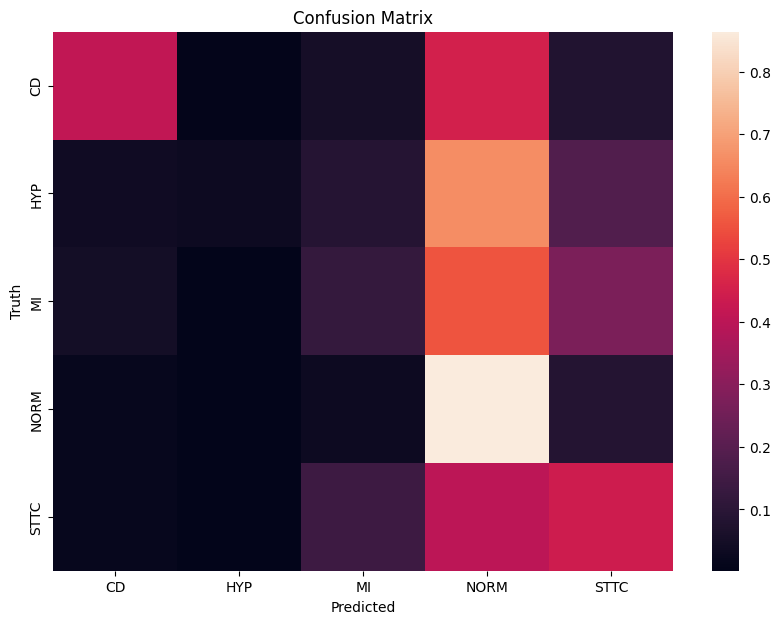

In [48]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['CD','HYP','MI','NORM','STTC']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


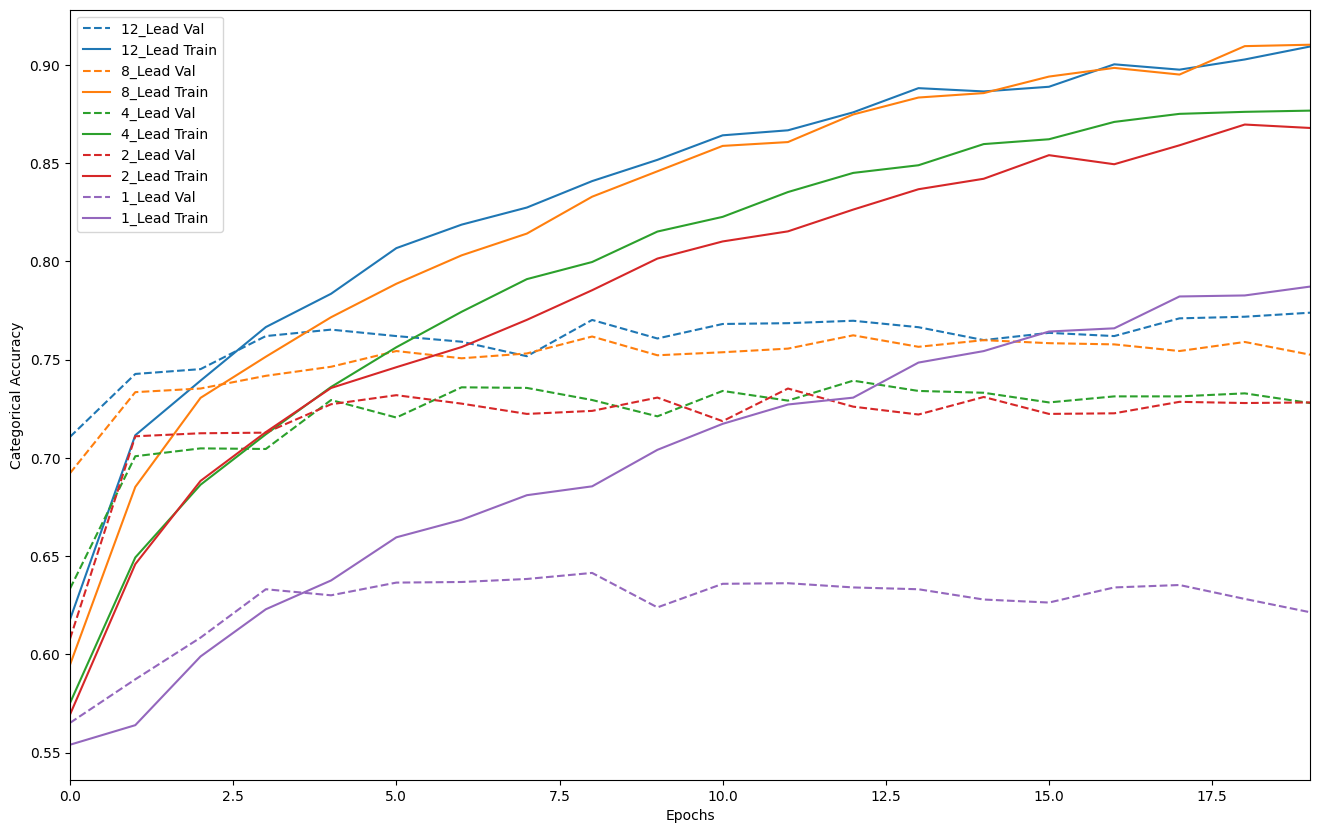

In [49]:
def plot_history(histories, key='categorical_accuracy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_history([('12_lead', history_12),
              ('8_lead', history_8),
              ('4_lead', history_4),
              ('2_lead', history_2),
              ('1_lead', history_1)])


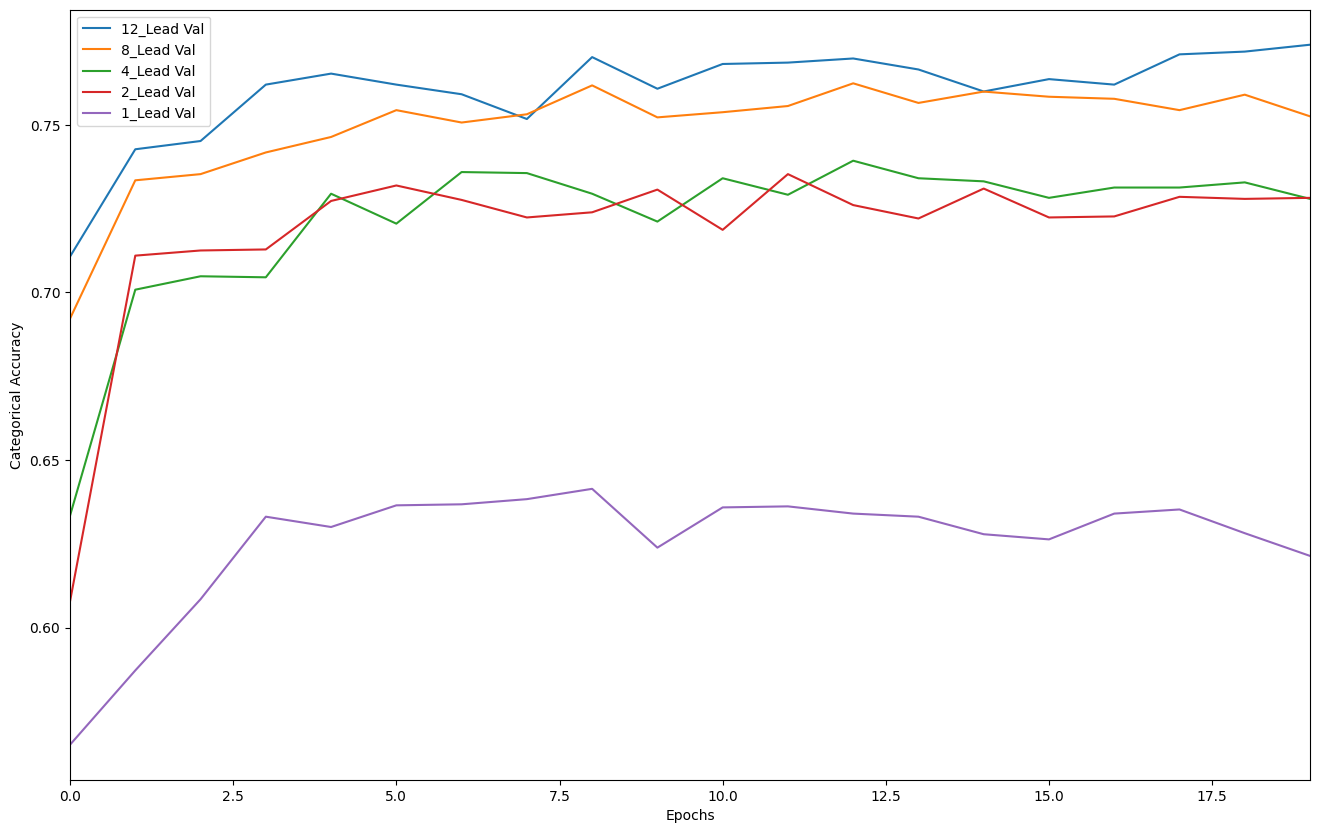

In [56]:
def plot_history(histories, key='categorical_accuracy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key]
                       , label=name.title()+' Val')


    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_history([('12_lead', history_12),
              ('8_lead', history_8),
              ('4_lead', history_4),
              ('2_lead', history_2),
              ('1_lead', history_1)])


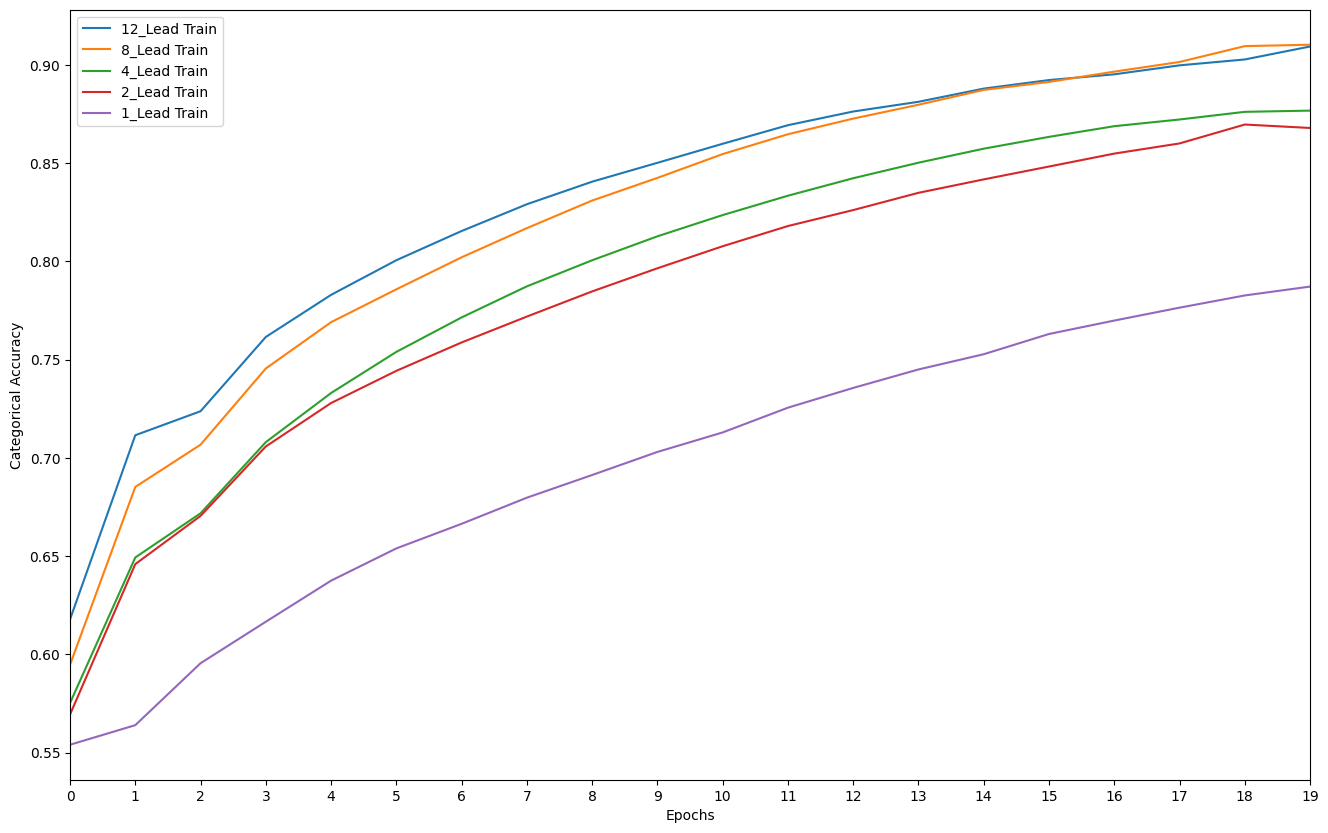

In [51]:
def plot_smooth_history(histories, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history[key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_history([('12_lead', history_12),
                     ('8_lead', history_8),
                     ('4_lead', history_4),
                     ('2_lead', history_2),
                     ('1_lead', history_1)])


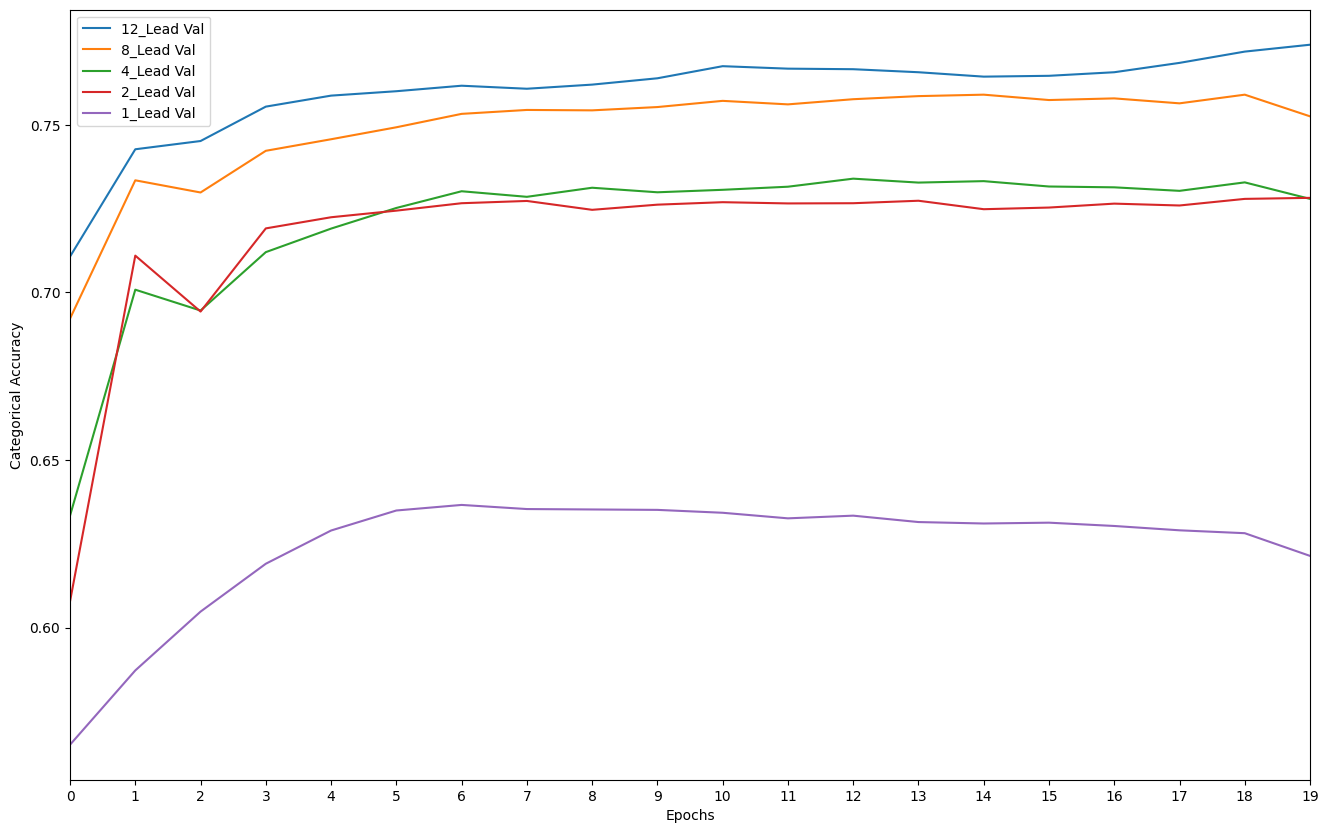

In [52]:
def plot_smooth_history(histories, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history['val_'+key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Val')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_history([('12_lead', history_12),
                     ('8_lead', history_8),
                     ('4_lead', history_4),
                     ('2_lead', history_2),
                     ('1_lead', history_1)])


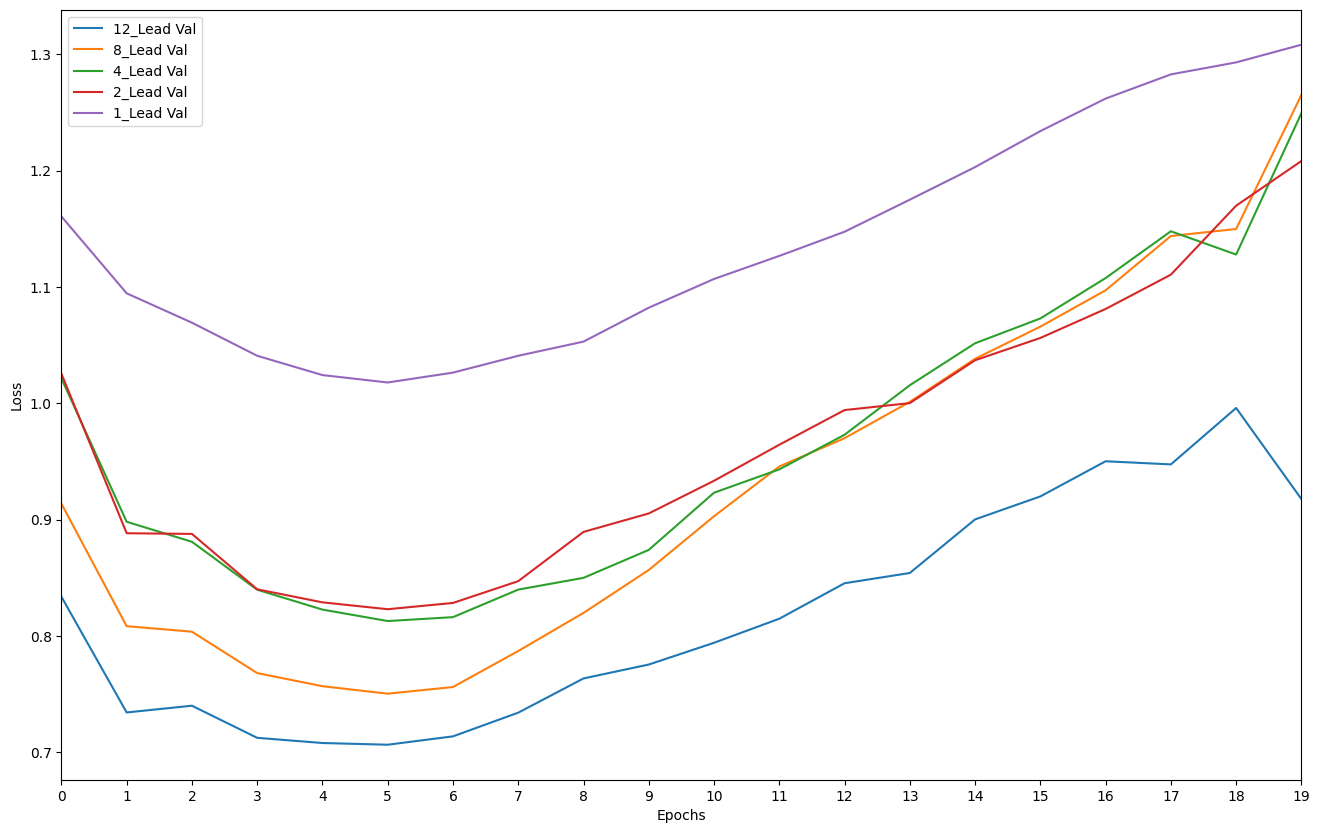

In [53]:
def plot_smooth_loss(histories, key='loss', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history['val_'+key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Val')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_loss([('12_lead', history_12),
                  ('8_lead', history_8),
                  ('4_lead', history_4),
                  ('2_lead', history_2),
                  ('1_lead', history_1)])


todo:
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert?
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

- checker la normalisation
- passer en 250 sample rate

Done:
- remove last beat (when 0 volt)